<img src="https://bit.ly/2VnXWr2" width="100" align="left">

# Final project: NLP to predict Myers-Briggs Personality Type

## Imports

In [142]:
# Data Analysis
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import umap.plot
from yellowbrick.text import UMAPVisualizer

# Data Visualization for text
from PIL import Image
from os import path
import os
import random
from wordcloud import WordCloud, STOPWORDS

# Text Processing
import re
import itertools
import spacy
import string
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from collections import Counter

### Dimensionality reduction and embedding
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# Machine Learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import sklearn.cluster as cluster
from sklearn.preprocessing import LabelEncoder

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

# Export data
import pickle
from scipy import sparse
from numpy import asarray
from numpy import savetxt

pd.set_option("display.max_column", None)

## 2. Data preprocessing

In [76]:
mbti_df = pd.read_csv("../your-project/data/mbti_1.csv")

### Cleaning text

In [77]:
type = ["type"]
posts = ["posts"]
columns = [*type, *posts]

In [78]:
mbti_df_raw = mbti_df
mbti_df_raw[type] = mbti_df[type].fillna("")
mbti_df_raw[posts] = mbti_df[posts].fillna("")
mbti_df_raw.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


#### Declare preprocessing functions

##### Cleaning functions

In [48]:
def clean_url(str_text_raw):
    """This function eliminate a string URL in a given text"""
    str_text = re.sub("url_\S+", "", str_text_raw)
    str_text = re.sub("email_\S+", "", str_text)
    str_text = re.sub("phone_\S+", "", str_text)
    return(re.sub("http[s]?://\S+", "", str_text))
    
def clean_punctuation(str_text_raw):
    """This function replace some of the troublemaker puntuation elements in a given text"""
    return(re.sub("[$\(\)/|{|\}#~\[\]^#;:!?¿]", " ", str_text_raw))

def clean_unicode(str_text_raw):
    """This function eliminate non-unicode text"""
    str_text = re.sub("&amp;", "", str_text_raw)
    return(re.sub(r"[^\x00-\x7F]+"," ", str_text))
                      
def clean_dot_words(str_text_raw):
    """This function replace dots between words"""
    return(re.sub(r"(\w+)\.+(\w+)", r"\1 \2",str_text_raw))

def clean_text(str_text_raw):
    """This function sets the text to lowercase and applies previous cleaning functions """
    str_text = str_text_raw.lower()
    str_text = clean_dot_words(clean_punctuation(clean_unicode(clean_url(str_text))))
    return(str_text)

##### Tokenization and lemmatization functions

In [49]:
tokens_to_drop=["+"]

def string_to_token(string, str_pickle = None):
    """
    This function takes a sentence and returns the list of tokens and all their information
    * Text: The original text of the lemma.
    * Lemma: Lemma.
    * Orth: The hash value of the lemma.
    * is alpha: Does the lemma consist of alphabetic characters?
    * is digit: Does the lemma consist of digits?
    * is_title: Is the token in titlecase? 
    * is_punct: Is the token punctuation?
    * is_space: Does the token consist of whitespace characters?
    * is_stop: Is the token part of a “stop list”?
    * is_digit: Does the token consist of digits?
    * lang: Language of the token
    * tag: Fine-grained part-of-speech. The complete list is in: 
    https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html, also using: spacy.explain("RB")
    * pos: Coarse-grained part-of-speech.
    * has_vector: A boolean value indicating whether a word vector is associated with the token.
    * vector_norm: The L2 norm of the token’s vector representation.
    * is_ovv: """
    doc = nlp(string)
    l_token = [[token.text, token.lemma_, token.orth, token.is_alpha, token.is_digit, token.is_title, token.lang_, 
        token.tag_, token.pos_, token.has_vector, token.vector_norm, token.is_oov]
        for token in doc if not token.is_punct | token.is_space | token.is_stop | token.is_digit | token.like_url 
               | token.like_num | token.like_email & token.is_oov]
    pd_token = pd.DataFrame(l_token, columns=["text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language",
                                          "tag", "part_of_speech", "has_vector", "vector_norm", "is_oov"])
    #drop problematic tokens
    pd_token = pd_token[~pd_token["text"].isin(tokens_to_drop)]
    #Convert plural text to singular
    pd_token["text_to_singular"] = np.where(pd_token["tag"].isin(["NNPS", "NNS"]), pd_token["lemma"], pd_token["text"])
    if(str_pickle!=None):
        pd_token.to_pickle(f"data/output_pickles/{str_pickle}.pkl") #Modified
    del l_token
    return(pd_token)

def apply_cleaning(string):
    """
    This function takes a sentence and returns a clean text
    """
    doc = nlp(clean_text(string))
    l_token = [token.text for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return " ".join(l_token)

def apply_lemma(string):
    """
    This function takes a sentence and returns a clean text
    """
    doc = nlp(clean_text(string))
    l_token = [token.lemma_ for token in doc if not token.is_punct | token.is_space | token.is_stop | 
               token.is_digit | token.like_url | token.like_num | token.like_email & token.is_oov]
    return " ".join(l_token)

def list_to_bow(l_words):
    """
    This function takes a list of words and create the bag of words ordered by desc order
    """
    cv = CountVectorizer(l_words)
    # show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
    count_vector=cv.fit_transform(l_words)
    word_freq = Counter(l_words)
    print(f"Bag of words size: {count_vector.shape}\nUnique words size: {len(word_freq)}")
    dict_word_freq = dict(word_freq.most_common())
    return(dict_word_freq)

#### Clean data

In [50]:
mbti_df_clean = pd.DataFrame(mbti_df_raw[["type", "posts"]])
for c in columns:
    mbti_df_clean[c] = mbti_df_raw[c].apply(lambda row: clean_text(row))
mbti_df_clean["posts"] = mbti_df_raw[posts].apply(lambda x: " ".join(x), axis=1)
mbti_df_clean.head()

,type,posts
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,entp,'I'm finding the lack of me in these posts ver...
2,intp,'Good one _____ https://www.youtube.com/wat...
3,intj,"'Dear INTP, I enjoyed our conversation the o..."
4,entj,'You're fired.|||That's another silly misconce...


<img src="https://www.nicepng.com/png/detail/148-1486992_discover-the-most-powerful-ways-to-automate-your.png" width="1000"> 

In [8]:
raise SystemExit("This is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step")

SystemExit: This is a very consumming memory process, with average wall time: ~ 20 min. If you don't want to wait please go to the next step

In [51]:
nlp = spacy.load("en_core_web_sm", disable = ["ner", "parser"]) 
nlp.max_length = 33000000

In [ ]:
mbti_df_clean.shape

In [ ]:
mbti_df_clean_first = mbti_df_clean.iloc[:2169]

In [ ]:
mbti_df_clean_second = mbti_df_clean[2169:4338]

In [ ]:
mbti_df_clean_third = mbti_df_clean.iloc[4338:6507]

In [ ]:
mbti_df_clean_fourth = mbti_df_clean.iloc[6507:8675]

#### End cleaning and tokenize rows using spaCy

In [ ]:
%%time
for column in columns:    
    str_bow_column_first = " ".join(mbti_df_clean_first[column])
    pd_token_first = string_to_token(str_bow_column_first, f"token_first_{column}")
    print(f"Length of {column} column: {len(str_bow_column_first)}")
    print(f"Number of tokens created: {pd_token_first.shape[0]}\n")

In [ ]:
%%time
for column in columns:    
    str_bow_column_second = " ".join(mbti_df_clean_second[column])
    pd_token_second = string_to_token(str_bow_column_second, f"token_second_{column}")
    print(f"Length of {column} column: {len(str_bow_column_second)}")
    print(f"Number of tokens created: {pd_token_second.shape[0]}\n")

In [ ]:
%%time
for column in columns:    
    str_bow_column_third = " ".join(mbti_df_clean_third[column])
    pd_token_third = string_to_token(str_bow_column_third, f"token_third_{column}")
    print(f"Length of {column} column: {len(str_bow_column_third)}")
    print(f"Number of tokens created: {pd_token_third.shape[0]}\n")

In [ ]:
%%time
for column in columns:    
    str_bow_column_fourth = " ".join(mbti_df_clean_fourth[column])
    pd_token_fourth = string_to_token(str_bow_column_fourth, f"token_fourth_{column}")
    print(f"Length of {column} column: {len(str_bow_column_fourth)}")
    print(f"Number of tokens created: {pd_token_fourth.shape[0]}\n")

#### Load the pickles into Dataframe

In [79]:
%%time
pd_token_first = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_first_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_first = pd.concat([pd_token_first, pd_temp])
print(f"Total rows loaded: {pd_token_first.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1154000 rows
Total rows loaded: 1156169
Wall time: 1.8 s


In [80]:
%%time
pd_token_second = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_second_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_second = pd.concat([pd_token_second, pd_temp])
print(f"Total rows loaded: {pd_token_second.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1152931 rows
Total rows loaded: 1155100
Wall time: 1.81 s


In [81]:
%%time
pd_token_third = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_third_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_third = pd.concat([pd_token_third, pd_temp])
print(f"Total rows loaded: {pd_token_third.shape[0]}")

Loading type info with 2169 rows
Loading posts info with 1152444 rows
Total rows loaded: 1154613
Wall time: 1.79 s


In [82]:
%%time
pd_token_fourth = pd.DataFrame(columns=["column", "text", "lemma", "orth", "is_alpha", "is_digit", "is_title", "language", "tag", 
                                 "part_of_speech", "has_vector", "vector_norm", "is_oov", "text_to_singular"])
for column in columns:
    pd_temp = pd.read_pickle(f"data/output_pickles/token_fourth_{column}.pkl") #Modified
    pd_temp["column"] = column
    print(f"Loading {column} info with {pd_temp.shape[0]} rows")
    pd_token_fourth = pd.concat([pd_token_fourth, pd_temp])
print(f"Total rows loaded: {pd_token_fourth.shape[0]}")

Loading type info with 2168 rows
Loading posts info with 1167724 rows
Total rows loaded: 1169892
Wall time: 1.81 s


In [83]:
pd_token_first.head()


,column,text,lemma,orth,is_alpha,is_digit,is_title,language,tag,part_of_speech,has_vector,vector_norm,is_oov,text_to_singular
0,type,infj,infj,11268318518583253733,True,False,False,en,NNP,PROPN,True,22.320921,True,infj
1,type,entp,entp,9138091435026282108,True,False,False,en,NNP,PROPN,True,19.919392,True,entp
2,type,intp,intp,10969288439530978247,True,False,False,en,NNP,PROPN,True,19.970396,True,intp
3,type,intj,intj,421,True,False,False,en,NN,NOUN,True,18.208828,True,intj
4,type,entj,entj,13346206504721371118,True,False,False,en,NN,NOUN,True,18.694639,True,entj


In [84]:
pd_token_first.tail()

,column,text,lemma,orth,is_alpha,is_digit,is_title,language,tag,part_of_speech,has_vector,vector_norm,is_oov,text_to_singular
1154338,posts,INFP,INFP,3649878657138915199,True,False,False,en,NNP,PROPN,True,22.079365,True,INFP
1154339,posts,males,male,8448926857789959353,True,False,False,en,NNS,NOUN,True,20.209568,True,male
1154340,posts,feel,feel,5741770584995928333,True,False,False,en,VBP,VERB,True,21.948505,True,feel
1154341,posts,inadequate,inadequate,17995393726734896709,True,False,False,en,JJ,ADJ,True,20.641933,True,inadequate
1154342,posts,male,male,17309040611306787464,True,False,False,en,NN,NOUN,True,19.141657,True,male


#### Add cleaned info to the dataset and store it into a pickle

In [13]:
mbti_df_clean['type_clean'] = mbti_df_clean['type'].apply(lambda x: apply_cleaning(x))
mbti_df_clean['posts_clean']   = mbti_df_clean['posts'].apply(lambda x: apply_cleaning(x))
mbti_df_clean['type_lemma'] = mbti_df_clean['type'].apply(lambda x: apply_lemma(x))
mbti_df_clean['posts_lemma']   = mbti_df_clean['posts'].apply(lambda x: apply_lemma(x))
mbti_df_clean.head()

KeyboardInterrupt: 

In [ ]:
mbti_df_clean.shape

In [ ]:
mbti_df_clean.to_pickle('data/output_pickles/mbti_clean_text.pkl')

In [85]:
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")

### TF-IDF

In [91]:
mbti_text = mbti_df[["type","posts"]].copy()

In [235]:
mbti_text = mbti_text.fillna("")
text_columns = mbti_text[["type"]]
text_columns["text"] = mbti_text.iloc[:,1:].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [236]:
text_columns.head()

,type,text
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [237]:
text_columns = pd.DataFrame()
text_columns["type"] = mbti_df_clean[["type_lemma"]].apply(lambda row: " ".join(row.values.astype(str)), axis=1)
text_columns["text"] = mbti_df_clean[["posts_lemma"]].apply(lambda row: " ".join(row.values.astype(str)), axis=1)

In [238]:
text_columns.head()

,type,text
0,infj,intj moment sportscent play prank life change ...
1,entp,find lack post alarming sex bore position exam...
2,intp,good course know blessing curse absolutely pos...
3,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,fire silly misconception approach logically go...


In [239]:
text_columns['text'].isnull().sum()

0

In [209]:
tfidf = TfidfVectorizer().fit_transform(text_columns['text'])

In [210]:
tfidf.shape

(8675, 88023)

In [211]:
sparse.save_npz("data/output_sparse/tfidf.npz", tfidf)

In [212]:
tfidf_df = pd.DataFrame(tfidf)

In [213]:
tfidf_df.to_csv("data/output_csv/tfidf_df.csv")

In [214]:
tfidf_df.head()

,0
0,"(0, 52925)\t0.02457857898730888\n (0, 72839..."
1,"(0, 78387)\t0.045110794601750416\n (0, 2034..."
2,"(0, 40085)\t0.03322273941193883\n (0, 63157..."
3,"(0, 73593)\t0.04268231701772938\n (0, 72871..."
4,"(0, 63844)\t0.0677461366096841\n (0, 10809)..."


### Dimensionlity reduction

#### Label encoding

In [215]:
possible_types= ["infj", "entp", "intp", "intj", "entj", "enfj", "infp", "enfp", "isfp", "istp", "isfj", "istj", "estp", "esfp", "estj", "esfj"]
lab_encoder = LabelEncoder().fit(possible_types)

In [216]:
def encode_personalities(text_columns):

    list_personality = []
    len_data = len(text_columns)
    i=0
    
    for row in text_columns.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        type_labelized = lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)

    #del data
    list_personality = np.array(list_personality)
    return list_personality

list_personality = encode_personalities(text_columns)

500 | 8675 rows
1000 | 8675 rows
1500 | 8675 rows
2000 | 8675 rows
2500 | 8675 rows
3000 | 8675 rows
3500 | 8675 rows
4000 | 8675 rows
4500 | 8675 rows
5000 | 8675 rows
5500 | 8675 rows
6000 | 8675 rows
6500 | 8675 rows
7000 | 8675 rows
7500 | 8675 rows
8000 | 8675 rows
8500 | 8675 rows


In [217]:
savetxt("data/output_csv/personality.csv", list_personality, delimiter=",")
list_personality

array([ 8,  3, 11, ..., 11,  9,  9], dtype=int64)

#### Truncated SVD and TSNE

In [218]:
svd = TruncatedSVD(n_components=16, n_iter=10, random_state=42)
svd_vec = svd.fit_transform(tfidf)

print("TSNE")
X_tsne = TSNE(n_components=3, verbose=1, perplexity=40).fit_transform(svd_vec)

TSNE
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8675 samples in 0.030s...
[t-SNE] Computed neighbors for 8675 samples in 3.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8675
[t-SNE] Computed conditional probabilities for sample 2000 / 8675
[t-SNE] Computed conditional probabilities for sample 3000 / 8675
[t-SNE] Computed conditional probabilities for sample 4000 / 8675
[t-SNE] Computed conditional probabilities for sample 5000 / 8675
[t-SNE] Computed conditional probabilities for sample 6000 / 8675
[t-SNE] Computed conditional probabilities for sample 7000 / 8675
[t-SNE] Computed conditional probabilities for sample 8000 / 8675
[t-SNE] Computed conditional probabilities for sample 8675 / 8675
[t-SNE] Mean sigma: 0.049530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.372070
[t-SNE] KL divergence after 1000 iterations: 2.141501


In [219]:
X_tsne

array([[-17.382927  ,  -1.5033937 ,   0.42617616],
       [  4.1042686 , -17.381323  , -10.940951  ],
       [ -9.092118  ,  -4.7440886 ,  -1.232161  ],
       ...,
       [ -8.706706  ,  -2.0131276 ,  -8.948842  ],
       [ 15.703634  ,  -1.7125235 ,   5.708145  ],
       [ 12.025861  ,   3.2485476 ,  15.205831  ]], dtype=float32)

In [220]:
X_tsne_df = pd.DataFrame(X_tsne)
print(X_tsne_df[0].min())
print(X_tsne_df[0].max())
print(X_tsne_df[1].min())
print(X_tsne_df[1].max())
print(X_tsne_df[2].min())
print(X_tsne_df[2].max())

-30.634803771972656
28.764080047607422
-24.439579010009766
29.512985229492188
-32.71210479736328
34.45693588256836


In [221]:
X_tsne_positive = X_tsne-X_tsne_df[0].min()
X_tsne_positive

array([[13.251877, 29.13141 , 31.06098 ],
       [34.73907 , 13.253481, 19.693851],
       [21.542686, 25.890715, 29.402643],
       ...,
       [21.928097, 28.621675, 21.685963],
       [46.33844 , 28.92228 , 36.34295 ],
       [42.660664, 33.88335 , 45.840633]], dtype=float32)

In [222]:
text_columns_tsne = pd.DataFrame(X_tsne_positive)

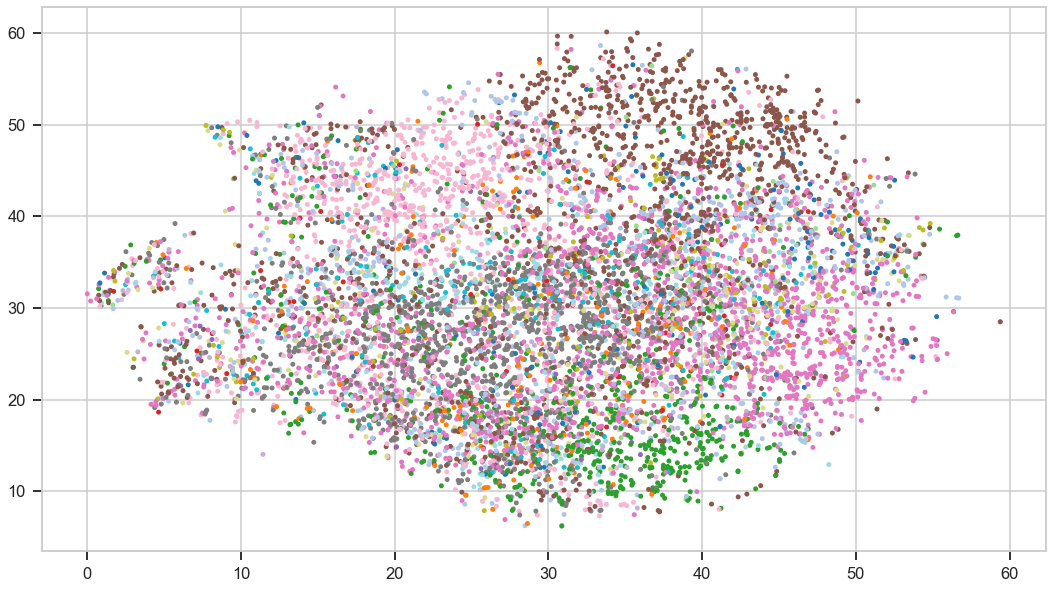

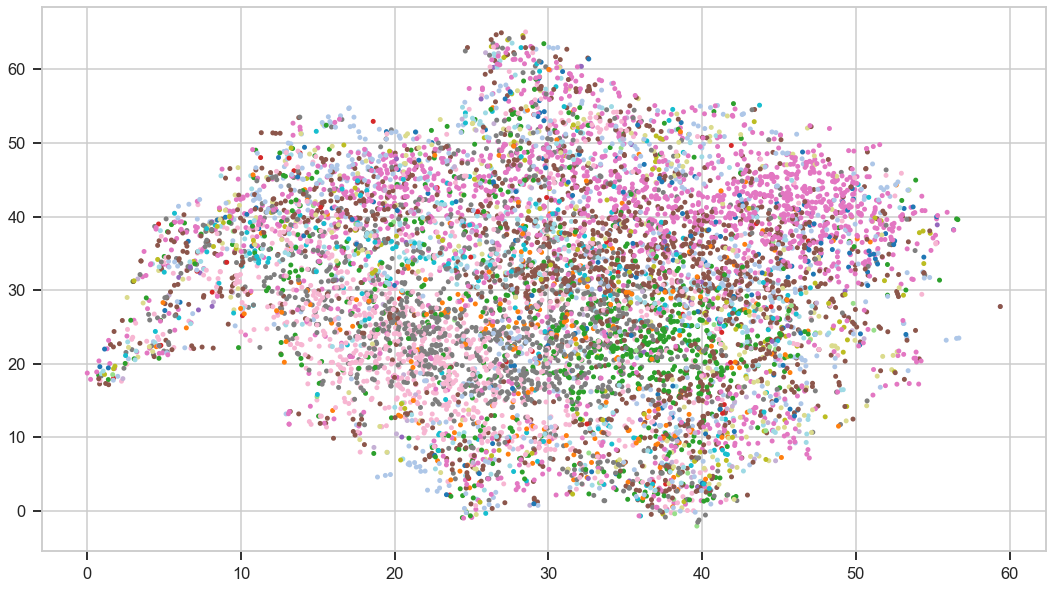

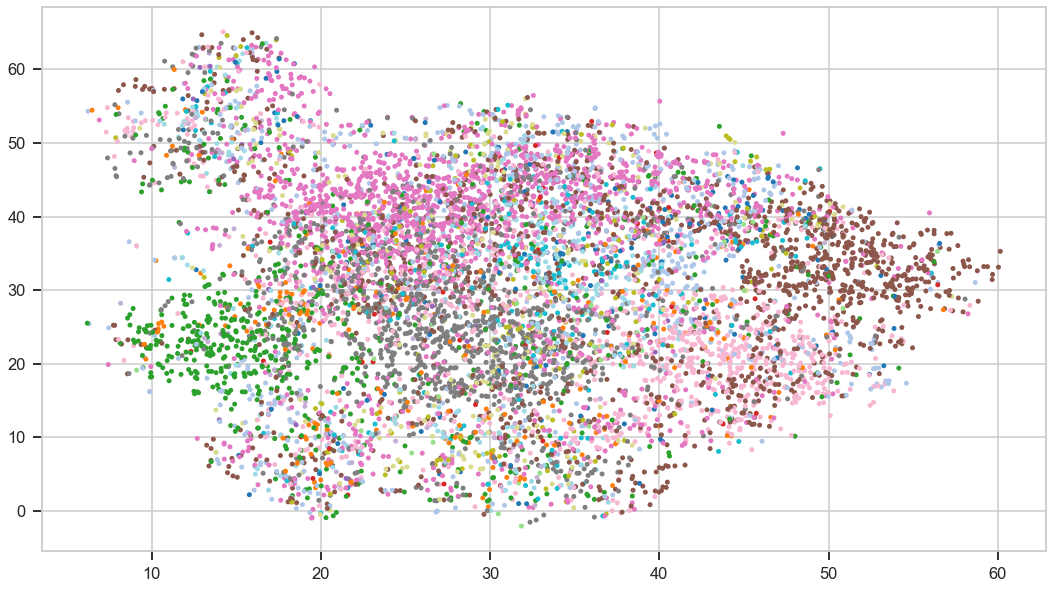

In [223]:
col = list_personality

plt.figure(0, figsize=(18,10))
plt.scatter(X_tsne_positive[:,0], X_tsne_positive[:,1], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.savefig("images/output_images/TSNE0.png")

plt.figure(1, figsize=(18,10))
plt.scatter(X_tsne_positive[:,0], X_tsne_positive[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.savefig("images/output_images/TSNE1.png")

plt.figure(2, figsize=(18,10))
plt.scatter(X_tsne_positive[:,1], X_tsne_positive[:,2], c=col, cmap=plt.get_cmap('tab20') , s=12)
plt.savefig("images/output_images/TSNE2.png")

sns.set_context("talk")
plt.show()

#### UMAP

In [224]:
embedding = umap.UMAP(metric='hellinger', random_state=42).fit_transform(tfidf)

In [225]:
embedding_df = pd.DataFrame(embedding)
print(embedding_df[0].min())
print(embedding_df[0].max())
print(embedding_df[1].min())
print(embedding_df[1].max())

-5.503086090087891
1.7559527158737183
-2.165020227432251
3.043438196182251


In [226]:
embedding_positive = embedding-embedding_df[0].min()
embedding_positive

array([[3.910143 , 7.4778743],
       [3.93804  , 5.9396358],
       [3.7401528, 5.486389 ],
       ...,
       [2.120136 , 4.0490603],
       [2.1481922, 6.1100335],
       [1.6514668, 6.033452 ]], dtype=float32)

In [227]:
text_columns_umap = pd.DataFrame(embedding_positive)

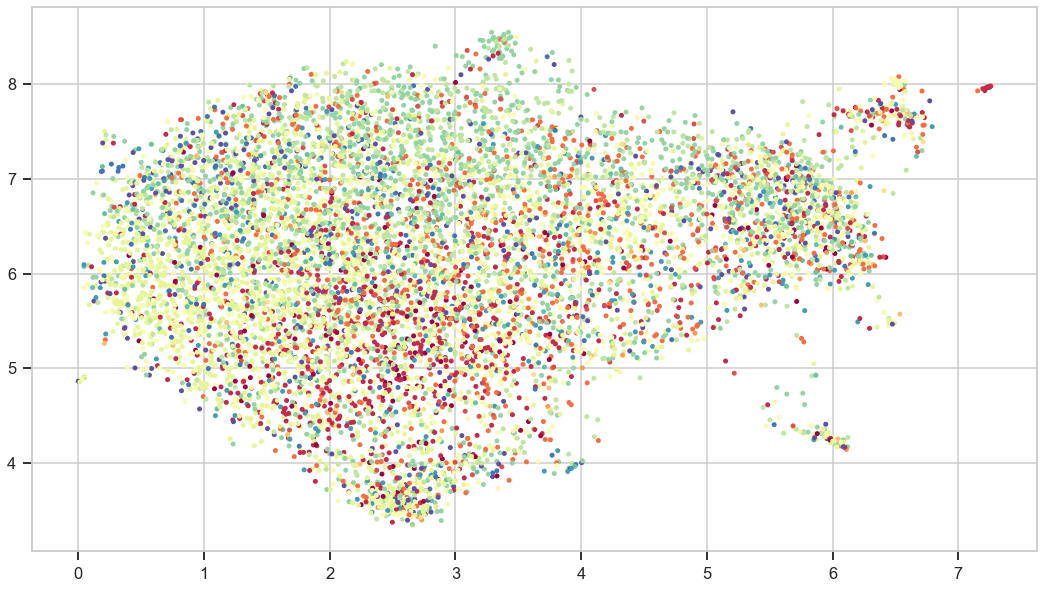

In [228]:
plt.figure(figsize=(18,10))
plt.scatter(embedding_positive[:, 0], embedding_positive[:, 1], c=col, cmap='Spectral', s=12)


sns.set_context("talk")
plt.savefig("images/output_images/UMAP_embedding_positive.png")
plt.show()

#### GloVe embedding

In [144]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [145]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

FileNotFoundError: [Errno 2] No such file or directory: 'glove/glove.6B.100d.txt'

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

### Get new numerical columns

I will get the original dataframe with its posts lengths and variances, dummies from every type and dummies on every type dimension axis.

In [240]:
def var_row(row):
    lst = []
    for word in row.split("|||"):
        lst.append(len(word.split()))
    return np.var(lst)

mbti_df["words_per_comment"] = mbti_df["posts"].apply(lambda x: len(x.split())/50)
mbti_df["variance_of_word_counts"] = mbti_df["posts"].apply(lambda x: var_row(x))

In [241]:
type_dummies = pd.get_dummies(text_columns["type"])
text_columns.drop(["text"], axis=1, inplace=True)
text_columns = pd.concat([text_columns, mbti_df["words_per_comment"], mbti_df["variance_of_word_counts"], 
                          type_dummies], axis=1,levels=None ,sort=False)

In [242]:
map1 = {"i": 0, "e": 1}
map2 = {"n": 0, "s": 1}
map3 = {"t": 0, "f": 1}
map4 = {"j": 0, "p": 1}
text_columns["i-e"] = text_columns["type"].astype(str).str[0]
text_columns["i-e"] = text_columns["i-e"].map(map1)
text_columns["n-s"] = text_columns["type"].astype(str).str[1]
text_columns["n-s"] = text_columns["n-s"].map(map2)
text_columns["t-f"] = text_columns["type"].astype(str).str[2]
text_columns["t-f"] = text_columns["t-f"].map(map3)
text_columns["j-p"] = text_columns["type"].astype(str).str[3]
text_columns["j-p"] = text_columns["j-p"].map(map4)

In [243]:
text_columns.head()

,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,i-e,n-s,t-f,j-p
0,infj,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,entp,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,intp,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,intj,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,entj,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Merge

I will merge the new numerical columns I created with the tfidf and different embedding results

#### Matrixes

##### Types

In [244]:
tfidf.shape

(8675, 88023)

In [245]:
tfidf_T = np.transpose(tfidf)

In [246]:
tfidf_T.shape

(88023, 8675)

In [247]:
list_personality.shape

(8675,)

In [248]:
train_array_T = sparse.vstack((list_personality, tfidf_T), format="csr")
train_array = np.transpose(train_array_T)

In [249]:
train_array

<8675x88024 sparse matrix of type '<class 'numpy.float64'>'
	with 2955962 stored elements in Compressed Sparse Column format>

In [250]:
train_array.shape

(8675, 88024)

##### Dimensions

#### TSNE

##### Dimensions

In [251]:
text_columns.drop(["type"], axis=1, inplace=True)
result_tsne_dimensions = pd.concat([text_columns, text_columns_tsne], axis=1,levels=None ,sort=False)

In [252]:
result_tsne_dimensions.drop(["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj", 
                             "intp", "isfj", "isfp", "istj", "istp"], axis=1, inplace=True)

In [253]:
result_tsne_dimensions.to_csv("data/output_csv/result_tsne_dimensions.csv")

In [254]:
result_tsne_dimensions.head()

,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1,2
0,11.12,135.2900,0,0,1,0,13.251877,29.131411,31.060980
1,23.40,187.4756,1,0,0,1,34.739071,13.253481,19.693851
2,16.72,180.6900,0,0,0,1,21.542686,25.890715,29.402643
3,21.28,181.8324,0,0,0,0,29.922289,22.042522,9.432224
4,19.34,196.4576,1,0,0,0,24.118402,18.166950,29.414555


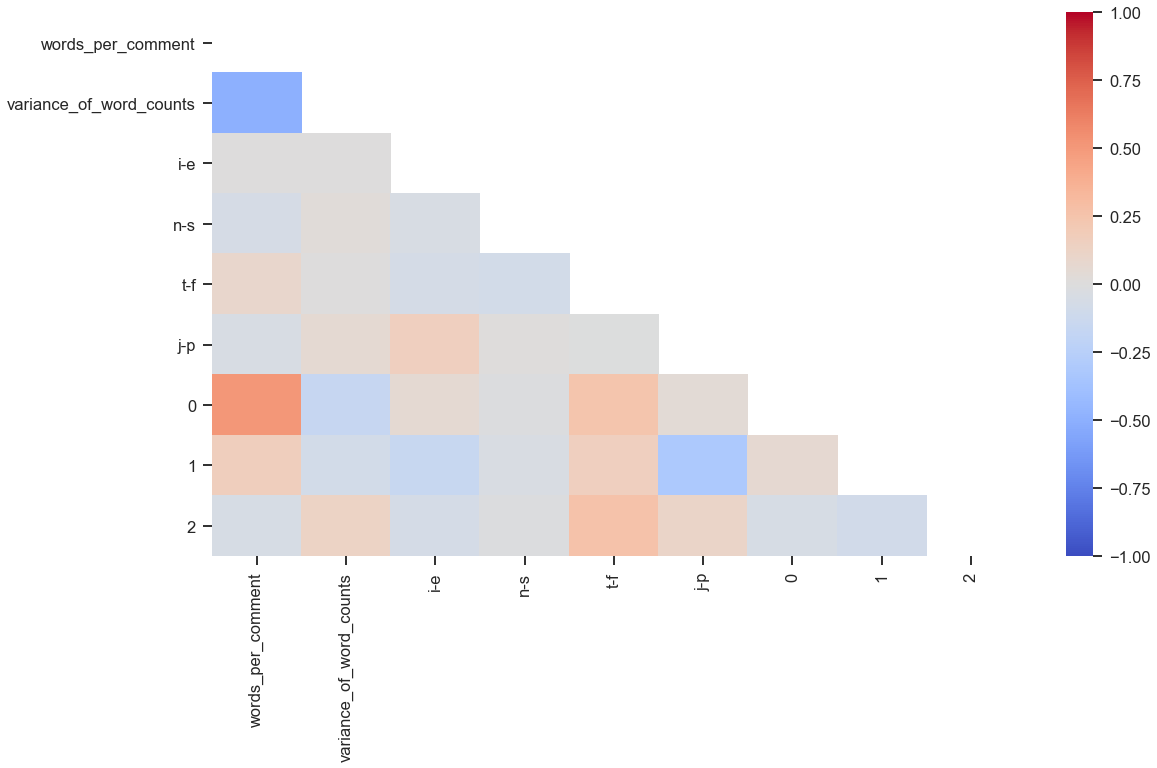

In [255]:
mask = np.triu(np.ones_like(result_tsne_dimensions.corr(), dtype=np.bool))
plt.figure(figsize=(18,10))
sns.heatmap(result_tsne_dimensions.corr(), mask=mask, cmap='coolwarm', vmin=-1, vmax=1) 
sns.set_context("talk")
plt.show()

##### Types

In [256]:
result_tsne_types = pd.concat([text_columns, text_columns_tsne], axis=1,levels=None ,sort=False)

In [257]:
result_tsne_types.drop(["i-e", "n-s", "t-f", "j-p"], axis=1, inplace=True)

In [258]:
result_tsne_types.to_csv("data/output_csv/result_tsne_types.csv")

In [259]:
result_tsne_types.head()

,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1,2
0,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,13.251877,29.131411,31.060980
1,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,34.739071,13.253481,19.693851
2,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,21.542686,25.890715,29.402643
3,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,29.922289,22.042522,9.432224
4,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,24.118402,18.166950,29.414555


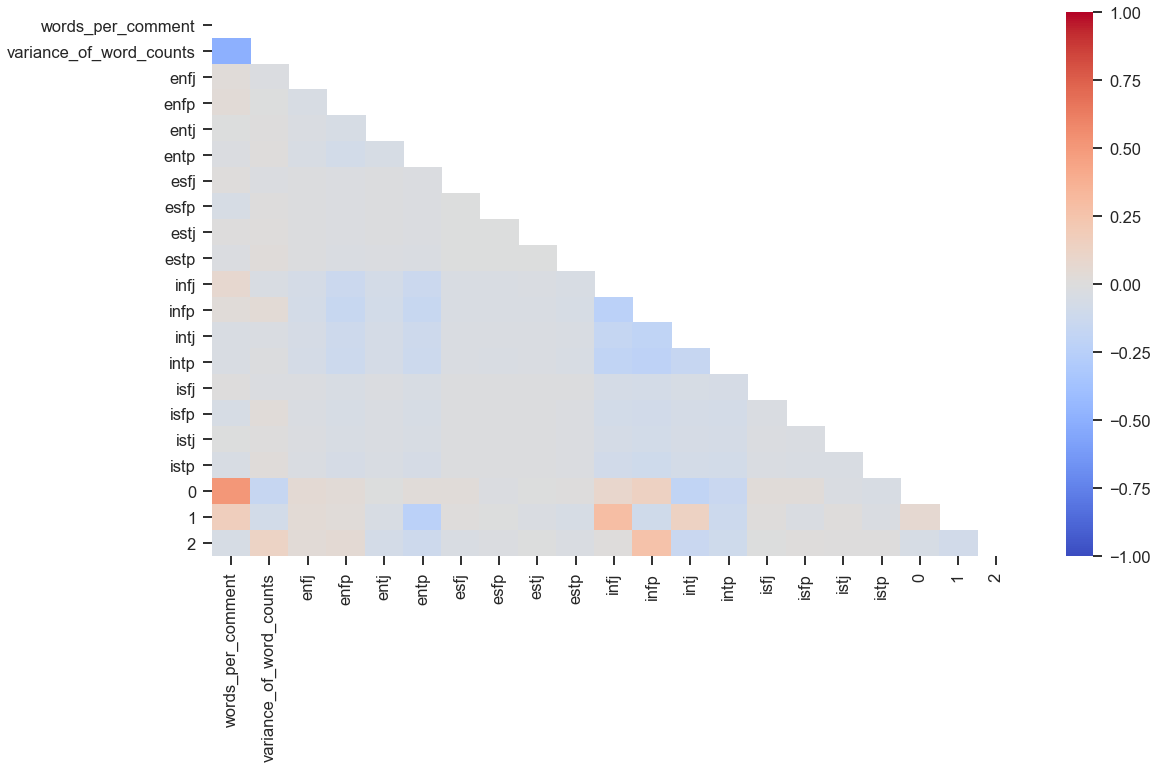

In [260]:
mask = np.triu(np.ones_like(result_tsne_types.corr(), dtype=np.bool))
plt.figure(figsize=(18,10))
sns.heatmap(result_tsne_types.corr(), mask=mask, cmap='coolwarm', vmin=-1, vmax=1) 
sns.set_context("talk")
plt.show()

#### UMAP

##### Dimensions

In [261]:
result_umap_dimensions = pd.concat([text_columns, text_columns_umap], axis=1,levels=None ,sort=False)

In [262]:
result_umap_dimensions.drop(["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp","infj", "infp", "intj", 
                             "intp", "isfj", "isfp", "istj", "istp"], axis=1, inplace=True)

In [263]:
result_umap_dimensions.to_csv("data/output_csv/result_umap_dimensions.csv")

In [264]:
result_umap_dimensions.head()

,words_per_comment,variance_of_word_counts,i-e,n-s,t-f,j-p,0,1
0,11.12,135.2900,0,0,1,0,3.910143,7.477874
1,23.40,187.4756,1,0,0,1,3.938040,5.939636
2,16.72,180.6900,0,0,0,1,3.740153,5.486389
3,21.28,181.8324,0,0,0,0,5.415134,7.452929
4,19.34,196.4576,1,0,0,0,2.083198,7.512875


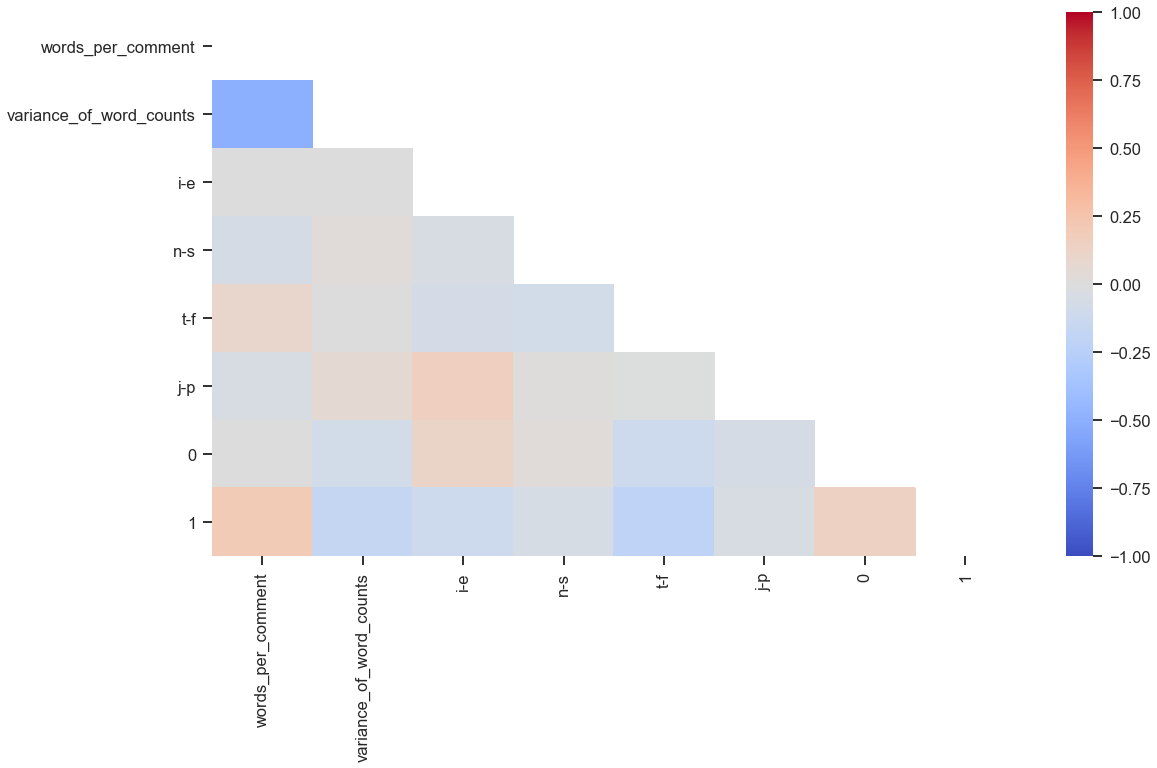

In [265]:
mask = np.triu(np.ones_like(result_umap_dimensions.corr(), dtype=np.bool))
plt.figure(figsize=(18,10))
sns.heatmap(result_umap_dimensions.corr(), mask=mask, cmap='coolwarm', vmin=-1, vmax=1) 
sns.set_context("talk")
plt.show()

##### Types

In [266]:
result_umap_types = pd.concat([text_columns, text_columns_umap], axis=1,levels=None ,sort=False)

In [267]:
result_umap_types.drop(["i-e", "n-s", "t-f", "j-p"], axis=1, inplace=True)

In [268]:
result_umap_types.to_csv("data/output_csv/result_umap_types.csv")

In [269]:
result_umap_types.head()

,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,estj,estp,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,11.12,135.2900,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.910143,7.477874
1,23.40,187.4756,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.938040,5.939636
2,16.72,180.6900,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.740153,5.486389
3,21.28,181.8324,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5.415134,7.452929
4,19.34,196.4576,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2.083198,7.512875


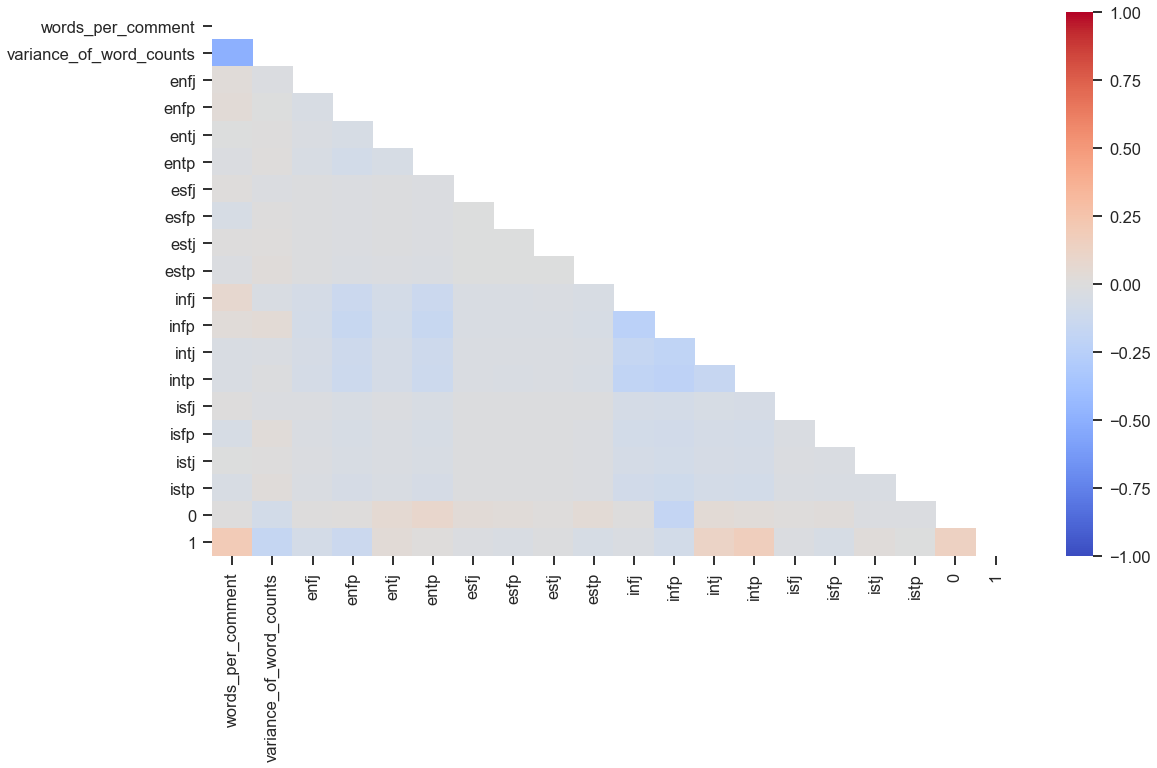

In [270]:
mask = np.triu(np.ones_like(result_umap_types.corr(), dtype=np.bool))
plt.figure(figsize=(18,10))
sns.heatmap(result_umap_types.corr(), mask=mask, cmap='coolwarm', vmin=-1, vmax=1) 
sns.set_context("talk")
plt.show()